In [3]:
cd '/content/drive/MyDrive/HEXR/Code'

/content/drive/MyDrive/HEXR/Code


In [5]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import supervised_models
import self_learning
import utils
from supervised_models import logit, mlp
from utils import mask_generator, pretext_generator
from self_learning import vime_self
from utils import perf_metric

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend

#to load VIME original

# from supervised_models import logit, mlp
# from vime_utils import mask_generator, pretext_generator
# from VIME.vime_self import vime_self
# from VIME.vime_utils import perf_metric

In [6]:
os.getcwd()

'/content/drive/MyDrive/HEXR/Code'

## HEXR on CASE with varying number of labelled data

In [ ]:
#Run this cell for CASE

df = pd.read_csv('../Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class2']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
15% :- Test 
10% of 85% = 8.5% :- Labelled dataset
90% of 85% = 76.5% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.15,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
len(x_unlab)

1125285

In [ ]:
# Self supervised training of encoder - 90% of train data.

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
  
# Train VIME-Self
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15
vime_self_encoder = vime_self(x_unlab, p_m, alpha, vime_self_parameters)
    
# Save encoder
if not os.path.exists('save_model'):
  os.makedirs('save_model')

file_name = '../Models/CASE_encoder.h5'
    
vime_self_encoder.save(file_name)  

Epoch 1/15
8792/8792 [==============================] - 36s 4ms/step - loss: 8.6695 - mask_loss: 0.6144 - feature_loss: 4.0276
Epoch 2/15
8792/8792 [==============================] - 33s 4ms/step - loss: 5.2504 - mask_loss: 0.6121 - feature_loss: 2.3191
Epoch 3/15
8792/8792 [==============================] - 33s 4ms/step - loss: 4.7598 - mask_loss: 0.6117 - feature_loss: 2.0741
Epoch 4/15
8792/8792 [==============================] - 33s 4ms/step - loss: 4.6377 - mask_loss: 0.6113 - feature_loss: 2.0132
Epoch 5/15
8792/8792 [==============================] - 32s 4ms/step - loss: 4.6057 - mask_loss: 0.6115 - feature_loss: 1.9971
Epoch 6/15
8792/8792 [==============================] - 32s 4ms/step - loss: 4.5716 - mask_loss: 0.6116 - feature_loss: 1.9800
Epoch 7/15
8792/8792 [==============================] - 33s 4ms/step - loss: 4.5199 - mask_loss: 0.6115 - feature_loss: 1.9542
Epoch 8/15
8792/8792 [==============================] - 32s 4ms/step - loss: 4.4925 - mask_loss: 0.6112 - featu

In [ ]:
logistic_supervised_acc = []
logistic_supervised_auc = []
mlp_supervised_acc = []
mlp_supervised_auc = []
self_supervised_acc = []
self_supervised_auc = []

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128

from keras.models import load_model
vime_self_encoder = load_model('../Models/CASE_encoder.h5')

for label_no in tqdm([1000,20000,40000,60000,80000,100000, len(label_idx)]):
  x_t = x_train[:label_no, :]
  y_t = y_train[:label_no, :]  

  y_test_hat = logit(x_t, y_t, x_test)
  logistic_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  logistic_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  y_test_hat = mlp(x_t, y_t, x_test, mlp_parameters)
  mlp_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  mlp_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_t)
  x_test_hat = vime_self_encoder.predict(x_test)
        
  y_test_hat = mlp(x_train_hat, y_t, x_test_hat, mlp_parameters)
  self_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  self_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  0%|          | 0/7 [00:00<?, ?it/s]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.
Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


 14%|█▍        | 1/7 [00:39<03:55, 39.32s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


 29%|██▊       | 2/7 [02:27<06:38, 79.61s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


 43%|████▎     | 3/7 [05:17<08:04, 121.20s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


 57%|█████▋    | 4/7 [09:54<09:08, 182.70s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


 71%|███████▏  | 5/7 [15:06<07:38, 229.20s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


 86%|████████▌ | 6/7 [21:51<04:49, 289.09s/it]

test3
Supervised MLP training sing Parameterized Elliot activation.
test3
Supervised MLP training sing Parameterized Elliot activation.


100%|██████████| 7/7 [30:31<00:00, 261.63s/it]


In [ ]:
logistic_supervised_acc

[0.6795879335037436,
 0.6766963978172984,
 0.6766012218777759,
 0.6764335309367125,
 0.6764833850002719,
 0.6763791446855568,
 0.6765332390638313]

In [ ]:
mlp_supervised_auc

[0.6294707808777823,
 0.7750982561010138,
 0.829857962936672,
 0.8421998206210648,
 0.8640369392360756,
 0.8682568521240643,
 0.8666504009550444]

In [ ]:
mlp_supervised_acc

[0.6614818440564891,
 0.7407316763655482,
 0.7778774859048966,
 0.7866155435905803,
 0.8021745436087091,
 0.7729283370497272,
 0.8049799677308244]

In [ ]:
self_supervised_auc

[0.5434188082097144,
 0.7829642232904042,
 0.857144924052031,
 0.862785287505124,
 0.8778236031770685,
 0.8742225672487993,
 0.8945101437598828]

In [ ]:
self_supervised_acc

array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  ,
       0.81179185, 0.82928156])

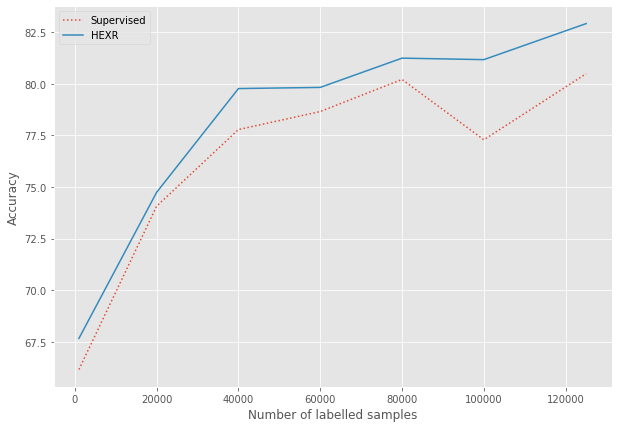

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1000,20000,40000,60000,80000,100000, len(label_idx)]
self_supervised_acc = np.array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  , 0.81179185, 0.82928156])
mlp_supervised_acc = np.array([0.6614818440564891,
 0.7407316763655482,
 0.7778774859048966,
 0.7866155435905803,
 0.8021745436087091,
 0.7729283370497272,
 0.8049799677308244])

plt.figure(figsize = (10,7))
plt.xlabel("Number of labelled samples")
plt.ylabel("Accuracy")
plt.plot(number_data, mlp_supervised_acc*100, ':', label = "Supervised")
plt.plot(number_data, self_supervised_acc*100, label = "HEXR")
plt.legend()

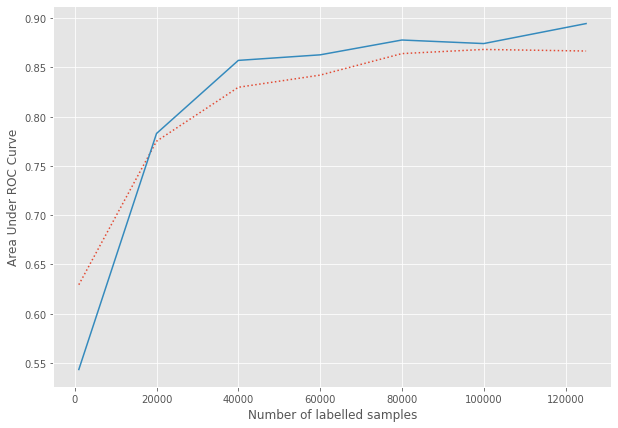

In [ ]:
#AUC
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1000,20000,40000,60000,80000,100000, len(label_idx)]
self_supervised_auc = np.array([0.5434188082097144,
 0.7829642232904042,
 0.857144924052031,
 0.862785287505124,
 0.8778236031770685,
 0.8742225672487993,
 0.8945101437598828])
mlp_supervised_auc = np.array([0.6294707808777823,
 0.7750982561010138,
 0.829857962936672,
 0.8421998206210648,
 0.8640369392360756,
 0.8682568521240643,
 0.8666504009550444])

plt.figure(figsize = (10,7))
plt.xlabel("Number of labelled samples")
plt.ylabel("Area Under ROC Curve")
plt.plot(number_data, mlp_supervised_auc, ':', label = "Supervised")
plt.plot(number_data, self_supervised_auc, label = "HEXR")

# Varying the number of unlabelled data 

In [20]:
#Run this cell for CASE

df = pd.read_csv('../Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class2']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
15% :- Test 
10% of 85% = 8.5% :- Labelled dataset
90% of 85% = 76.5% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.15,random_state=9) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [21]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [22]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [24]:
logistic_supervised_acc = []
logistic_supervised_auc = []
mlp_supervised_acc = []
mlp_supervised_auc = []

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128

# x_t = x_train[:label_no, :]
# y_t = y_train[:label_no, :]  

y_test_hat = logit(x_train, y_train, x_test)
logistic_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
logistic_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

y_test_hat = mlp(x_train, y_train, x_test, mlp_parameters)
mlp_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
mlp_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

test3
Supervised MLP training sing Parameterized Elliot activation.


In [25]:
logistic_supervised_acc

[0.6784322256666848]

In [26]:
mlp_supervised_acc

[0.8197730280451768]

In [27]:
mlp_supervised_auc

[0.8831913044911908]

In [12]:
len(x_unlab)

1125285

In [28]:
unlab_self_supervised_acc = []
unlab_self_supervised_auc = []
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15

for unlabelled_no in tqdm([100000,300000,500000,700000,900000,len(x_unlab)]):
  unlab = x_unlab[:unlabelled_no, :]
  print(len(unlab))
  vime_self_encoder = vime_self(unlab, p_m, alpha, vime_self_parameters)
  name_append = "CASE_encoder_unlabelled_seed2"+ str(unlabelled_no)
  file_name = "../Models/" + name_append + ".h5"
  vime_self_encoder.save(file_name)  
  print("encoder saved as : {}".format(file_name))
  x_train_hat = vime_self_encoder.predict(x_train)
  x_test_hat = vime_self_encoder.predict(x_test)
  y_test_hat = mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  unlab_self_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  unlab_self_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))
  print("Iteration {} done!".format(unlabelled_no))

  0%|          | 0/6 [00:00<?, ?it/s]

100000
Epoch 1/15
782/782 [==============================] - 4s 4ms/step - loss: 25.6107 - mask_loss: 0.6453 - feature_loss: 12.4827
Epoch 2/15
782/782 [==============================] - 3s 4ms/step - loss: 9.2426 - mask_loss: 0.6114 - feature_loss: 4.3156
Epoch 3/15
782/782 [==============================] - 3s 4ms/step - loss: 6.8458 - mask_loss: 0.6115 - feature_loss: 3.1171
Epoch 4/15
782/782 [==============================] - 3s 4ms/step - loss: 6.8273 - mask_loss: 0.6122 - feature_loss: 3.1075
Epoch 5/15
782/782 [==============================] - 3s 4ms/step - loss: 6.7845 - mask_loss: 0.6119 - feature_loss: 3.0863
Epoch 6/15
782/782 [==============================] - 3s 4ms/step - loss: 6.7310 - mask_loss: 0.6125 - feature_loss: 3.0593
Epoch 7/15
782/782 [==============================] - 3s 4ms/step - loss: 6.6674 - mask_loss: 0.6142 - feature_loss: 3.0266
Epoch 8/15
782/782 [==============================] - 3s 4ms/step - loss: 6.5006 - mask_loss: 0.6157 - feature_loss: 2.9424

encoder saved as : ../Models/CASE_encoder_unlabelled_seed2100000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 17%|█▋        | 1/6 [06:05<30:25, 365.08s/it]

Iteration 100000 done!
300000
Epoch 1/15
2344/2344 [==============================] - 10s 4ms/step - loss: 15.5860 - mask_loss: 0.6144 - feature_loss: 7.4858
Epoch 2/15
2344/2344 [==============================] - 9s 4ms/step - loss: 6.8423 - mask_loss: 0.6115 - feature_loss: 3.1154
Epoch 3/15
2344/2344 [==============================] - 9s 4ms/step - loss: 6.7709 - mask_loss: 0.6133 - feature_loss: 3.0788
Epoch 4/15
2344/2344 [==============================] - 9s 4ms/step - loss: 6.1418 - mask_loss: 0.6133 - feature_loss: 2.7642
Epoch 5/15
2344/2344 [==============================] - 9s 4ms/step - loss: 5.6068 - mask_loss: 0.6118 - feature_loss: 2.4975
Epoch 6/15
2344/2344 [==============================] - 9s 4ms/step - loss: 5.3486 - mask_loss: 0.6115 - feature_loss: 2.3685
Epoch 7/15
2344/2344 [==============================] - 11s 5ms/step - loss: 5.2156 - mask_loss: 0.6114 - feature_loss: 2.3021
Epoch 8/15
2344/2344 [==============================] - 9s 4ms/step - loss: 5.1560 - 

encoder saved as : ../Models/CASE_encoder_unlabelled_seed2300000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 33%|███▎      | 2/6 [12:40<25:31, 382.90s/it]

Iteration 300000 done!
500000
Epoch 1/15
3907/3907 [==============================] - 16s 4ms/step - loss: 11.3995 - mask_loss: 0.6144 - feature_loss: 5.3925
Epoch 2/15
3907/3907 [==============================] - 17s 4ms/step - loss: 5.9412 - mask_loss: 0.6142 - feature_loss: 2.6635
Epoch 3/15
3907/3907 [==============================] - 15s 4ms/step - loss: 5.4054 - mask_loss: 0.6127 - feature_loss: 2.3964
Epoch 4/15
3907/3907 [==============================] - 15s 4ms/step - loss: 5.1067 - mask_loss: 0.6118 - feature_loss: 2.2475
Epoch 5/15
3907/3907 [==============================] - 15s 4ms/step - loss: 4.8632 - mask_loss: 0.6113 - feature_loss: 2.1260
Epoch 6/15
3907/3907 [==============================] - 15s 4ms/step - loss: 4.6698 - mask_loss: 0.6112 - feature_loss: 2.0293
Epoch 7/15
3907/3907 [==============================] - 15s 4ms/step - loss: 4.5792 - mask_loss: 0.6112 - feature_loss: 1.9840
Epoch 8/15
3907/3907 [==============================] - 16s 4ms/step - loss: 4.5

encoder saved as : ../Models/CASE_encoder_unlabelled_seed2500000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 50%|█████     | 3/6 [20:42<21:23, 427.98s/it]

Iteration 500000 done!
700000
Epoch 1/15
5469/5469 [==============================] - 22s 4ms/step - loss: 9.4936 - mask_loss: 0.6166 - feature_loss: 4.4386
Epoch 2/15
5469/5469 [==============================] - 21s 4ms/step - loss: 5.5315 - mask_loss: 0.6127 - feature_loss: 2.4594
Epoch 3/15
5469/5469 [==============================] - 22s 4ms/step - loss: 5.1854 - mask_loss: 0.6115 - feature_loss: 2.2870
Epoch 4/15
5469/5469 [==============================] - 23s 4ms/step - loss: 4.9811 - mask_loss: 0.6114 - feature_loss: 2.1848
Epoch 5/15
5469/5469 [==============================] - 22s 4ms/step - loss: 4.7589 - mask_loss: 0.6114 - feature_loss: 2.0737
Epoch 6/15
5469/5469 [==============================] - 21s 4ms/step - loss: 4.6237 - mask_loss: 0.6113 - feature_loss: 2.0062
Epoch 7/15
5469/5469 [==============================] - 21s 4ms/step - loss: 4.5369 - mask_loss: 0.6111 - feature_loss: 1.9629
Epoch 8/15
5469/5469 [==============================] - 23s 4ms/step - loss: 4.47

encoder saved as : ../Models/CASE_encoder_unlabelled_seed2700000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 67%|██████▋   | 4/6 [31:17<16:59, 509.81s/it]

Iteration 700000 done!
900000
Epoch 1/15
7032/7032 [==============================] - 28s 4ms/step - loss: 9.8456 - mask_loss: 0.6139 - feature_loss: 4.6159
Epoch 2/15
7032/7032 [==============================] - 29s 4ms/step - loss: 5.9462 - mask_loss: 0.6120 - feature_loss: 2.6671
Epoch 3/15
7032/7032 [==============================] - 27s 4ms/step - loss: 5.0704 - mask_loss: 0.6119 - feature_loss: 2.2292
Epoch 4/15
7032/7032 [==============================] - 27s 4ms/step - loss: 4.7106 - mask_loss: 0.6117 - feature_loss: 2.0495
Epoch 5/15
7032/7032 [==============================] - 29s 4ms/step - loss: 4.5236 - mask_loss: 0.6113 - feature_loss: 1.9561
Epoch 6/15
7032/7032 [==============================] - 27s 4ms/step - loss: 4.4410 - mask_loss: 0.6113 - feature_loss: 1.9149
Epoch 7/15
7032/7032 [==============================] - 27s 4ms/step - loss: 4.3949 - mask_loss: 0.6112 - feature_loss: 1.8918
Epoch 8/15
7032/7032 [==============================] - 27s 4ms/step - loss: 4.36

encoder saved as : ../Models/CASE_encoder_unlabelled_seed2900000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 83%|████████▎ | 5/6 [42:49<09:35, 575.64s/it]

Iteration 900000 done!
1125285
Epoch 1/15
8792/8792 [==============================] - 35s 4ms/step - loss: 8.3457 - mask_loss: 0.6137 - feature_loss: 3.8660
Epoch 2/15
8792/8792 [==============================] - 36s 4ms/step - loss: 5.0341 - mask_loss: 0.6125 - feature_loss: 2.2108
Epoch 3/15
8792/8792 [==============================] - 34s 4ms/step - loss: 4.6968 - mask_loss: 0.6117 - feature_loss: 2.0426
Epoch 4/15
8792/8792 [==============================] - 34s 4ms/step - loss: 4.5929 - mask_loss: 0.6118 - feature_loss: 1.9906
Epoch 5/15
8792/8792 [==============================] - 35s 4ms/step - loss: 4.5138 - mask_loss: 0.6115 - feature_loss: 1.9511
Epoch 6/15
8792/8792 [==============================] - 34s 4ms/step - loss: 4.4489 - mask_loss: 0.6112 - feature_loss: 1.9188
Epoch 7/15
8792/8792 [==============================] - 34s 4ms/step - loss: 4.4052 - mask_loss: 0.6111 - feature_loss: 1.8970
Epoch 8/15
8792/8792 [==============================] - 36s 4ms/step - loss: 4.3

encoder saved as : ../Models/CASE_encoder_unlabelled_seed21125285.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


100%|██████████| 6/6 [57:02<00:00, 570.34s/it]

Iteration 1125285 done!


In [17]:
unlab_self_supervised_acc

[0.7964594550497635,
 0.7846032522978191,
 0.8214363408930222,
 0.7648791718786824,
 0.8245635503344755,
 0.7687043382099672]

In [18]:
unlab_self_supervised_auc

[0.8537279376026441,
 0.83866774999274,
 0.8858766330826763,
 0.8069353303005898,
 0.8886661832022588,
 0.8384750181247993]

In [29]:
unlab_self_supervised_acc

[0.7676438063124309,
 0.7492793821721869,
 0.8214227443302333,
 0.8205752252497235,
 0.7747366799006544,
 0.826376425372999]

In [30]:
unlab_self_supervised_auc

[0.8194865434538043,
 0.7892781436101074,
 0.8850311359819916,
 0.880957625178896,
 0.8341224464982515,
 0.8881943958592601]

In [33]:
unlab_self_supervised_acc_start = []
unlab_self_supervised_auc_start = []
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15

for unlabelled_no in tqdm([20000, 40000, 60000, 80000]):
  unlab = x_unlab[:unlabelled_no, :]
  print(len(unlab))
  vime_self_encoder = vime_self(unlab, p_m, alpha, vime_self_parameters)
  name_append = "CASE_encoder_unlabelled_seed2"+ str(unlabelled_no)
  file_name = "../Models/" + name_append + ".h5"
  vime_self_encoder.save(file_name)  
  print("encoder saved as : {}".format(file_name))
  x_train_hat = vime_self_encoder.predict(x_train)
  x_test_hat = vime_self_encoder.predict(x_test)
  y_test_hat = mlp(x_train_hat, y_train, x_test_hat, mlp_parameters)
  unlab_self_supervised_acc_start.append(perf_metric(metric1, y_test, y_test_hat))
  unlab_self_supervised_auc_start.append(perf_metric(metric2, y_test, y_test_hat))
  print("Iteration {} done!".format(unlabelled_no))

  0%|          | 0/4 [00:00<?, ?it/s]

20000
Epoch 1/15
157/157 [==============================] - 1s 4ms/step - loss: 36.1222 - mask_loss: 0.6604 - feature_loss: 17.7309
Epoch 2/15
157/157 [==============================] - 1s 4ms/step - loss: 33.1932 - mask_loss: 0.6216 - feature_loss: 16.2858
Epoch 3/15
157/157 [==============================] - 1s 4ms/step - loss: 28.5773 - mask_loss: 0.6168 - feature_loss: 13.9803
Epoch 4/15
157/157 [==============================] - 1s 6ms/step - loss: 24.2630 - mask_loss: 0.6129 - feature_loss: 11.8250
Epoch 5/15
157/157 [==============================] - 1s 7ms/step - loss: 20.2876 - mask_loss: 0.6130 - feature_loss: 9.8373
Epoch 6/15
157/157 [==============================] - 1s 7ms/step - loss: 16.0801 - mask_loss: 0.6130 - feature_loss: 7.7335
Epoch 7/15
157/157 [==============================] - 1s 6ms/step - loss: 11.9844 - mask_loss: 0.6126 - feature_loss: 5.6859
Epoch 8/15
157/157 [==============================] - 1s 6ms/step - loss: 9.3221 - mask_loss: 0.6122 - feature_loss

encoder saved as : ../Models/CASE_encoder_unlabelled_seed220000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 25%|██▌       | 1/4 [04:55<14:47, 295.71s/it]

Iteration 20000 done!
40000
Epoch 1/15
313/313 [==============================] - 2s 4ms/step - loss: 34.4367 - mask_loss: 0.7245 - feature_loss: 16.8561
Epoch 2/15
313/313 [==============================] - 1s 4ms/step - loss: 27.4113 - mask_loss: 0.6130 - feature_loss: 13.3991
Epoch 3/15
313/313 [==============================] - 1s 4ms/step - loss: 20.6829 - mask_loss: 0.6115 - feature_loss: 10.0357
Epoch 4/15
313/313 [==============================] - 1s 4ms/step - loss: 13.4027 - mask_loss: 0.6114 - feature_loss: 6.3956
Epoch 5/15
313/313 [==============================] - 1s 4ms/step - loss: 7.6685 - mask_loss: 0.6114 - feature_loss: 3.5285
Epoch 6/15
313/313 [==============================] - 1s 4ms/step - loss: 6.8457 - mask_loss: 0.6115 - feature_loss: 3.1171
Epoch 7/15
313/313 [==============================] - 1s 4ms/step - loss: 6.8443 - mask_loss: 0.6114 - feature_loss: 3.1164
Epoch 8/15
313/313 [==============================] - 1s 4ms/step - loss: 6.8436 - mask_loss: 0.6

encoder saved as : ../Models/CASE_encoder_unlabelled_seed240000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 50%|█████     | 2/4 [10:00<10:01, 300.89s/it]

Iteration 40000 done!
60000
Epoch 1/15
469/469 [==============================] - 3s 4ms/step - loss: 31.0742 - mask_loss: 0.6352 - feature_loss: 15.2195
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 22.3828 - mask_loss: 0.6109 - feature_loss: 10.8860
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 13.8259 - mask_loss: 0.6107 - feature_loss: 6.6076
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 7.6498 - mask_loss: 0.6107 - feature_loss: 3.5195
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 6.8693 - mask_loss: 0.6107 - feature_loss: 3.1293
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 6.8675 - mask_loss: 0.6111 - feature_loss: 3.1282
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 6.8662 - mask_loss: 0.6111 - feature_loss: 3.1275
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 6.8637 - mask_loss: 0.611

encoder saved as : ../Models/CASE_encoder_unlabelled_seed260000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


 75%|███████▌  | 3/4 [14:52<04:56, 296.83s/it]

Iteration 60000 done!
80000
Epoch 1/15
625/625 [==============================] - 3s 3ms/step - loss: 29.9704 - mask_loss: 0.6346 - feature_loss: 14.6679
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 17.2195 - mask_loss: 0.6109 - feature_loss: 8.3043
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 7.8528 - mask_loss: 0.6109 - feature_loss: 3.6209
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 6.8633 - mask_loss: 0.6109 - feature_loss: 3.1262
Epoch 5/15
625/625 [==============================] - 3s 5ms/step - loss: 6.8606 - mask_loss: 0.6111 - feature_loss: 3.1248
Epoch 6/15
625/625 [==============================] - 2s 3ms/step - loss: 6.8515 - mask_loss: 0.6112 - feature_loss: 3.1202
Epoch 7/15
625/625 [==============================] - 2s 3ms/step - loss: 6.8379 - mask_loss: 0.6114 - feature_loss: 3.1133
Epoch 8/15
625/625 [==============================] - 2s 3ms/step - loss: 6.8159 - mask_loss: 0.6117 

encoder saved as : ../Models/CASE_encoder_unlabelled_seed280000.h5
test3
Supervised MLP training sing Parameterized Elliot activation.


100%|██████████| 4/4 [20:18<00:00, 304.67s/it]

Iteration 80000 done!


In [34]:
unlab_self_supervised_acc_start

[0.6795969978789362,
 0.7467458893058502,
 0.7644939359329962,
 0.7582485814252824]

In [35]:
self_supervised_acc = unlab_self_supervised_acc_start + unlab_self_supervised_acc
self_supervised_acc

[0.6795969978789362,
 0.7467458893058502,
 0.7644939359329962,
 0.7582485814252824,
 0.7676438063124309,
 0.7492793821721869,
 0.8214227443302333,
 0.8205752252497235,
 0.7747366799006544,
 0.826376425372999]

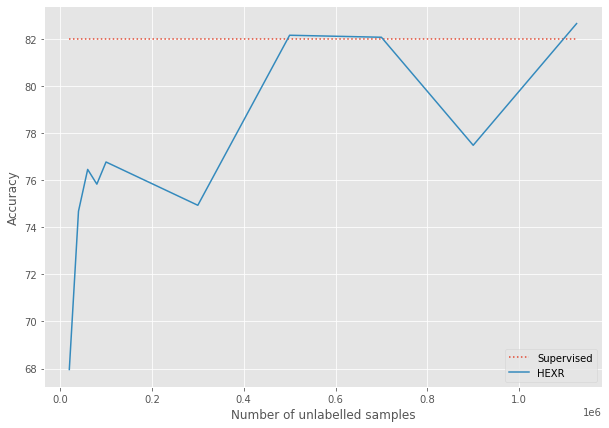

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [20000, 40000, 60000, 80000, 100000,300000,500000,700000,900000,len(x_unlab)]

supervised = np.array([0.8197730280451768, 0.8197730280451768, 0.8197730280451768, 0.8197730280451768, 0.8197730280451768,0.8197730280451768,0.8197730280451768,0.8197730280451768, 0.8197730280451768, 0.8197730280451768])
self_supervised_acc = np.array(unlab_self_supervised_acc_start + unlab_self_supervised_acc)

plt.figure(figsize = (10,7))
plt.xlabel("Number of unlabelled samples")
plt.ylabel("Accuracy")
plt.plot(number_data, supervised*100, ':', label = "Supervised")
plt.plot(number_data, self_supervised_acc*100, label = "HEXR")
plt.legend()